<a href="https://colab.research.google.com/github/YaZlob/ML_project/blob/master/TestTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!tar -xvf /content/gdrive/MyDrive/cats_dogs_dataset.tar

Выходные данные были обрезаны до нескольких последних строк (5000).
cats_dogs_dataset/train/american_pit_bull_terrier_183.jpg
cats_dogs_dataset/train/great_pyrenees_113.jpg
cats_dogs_dataset/train/scottish_terrier_162.jpg
cats_dogs_dataset/train/pug_147.txt
cats_dogs_dataset/train/Sphynx_130.jpg
cats_dogs_dataset/train/great_pyrenees_101.jpg
cats_dogs_dataset/train/chihuahua_102.jpg
cats_dogs_dataset/train/Maine_Coon_195.txt
cats_dogs_dataset/train/Birman_103.txt
cats_dogs_dataset/train/Persian_184.txt
cats_dogs_dataset/train/boxer_162.jpg
cats_dogs_dataset/train/yorkshire_terrier_148.txt
cats_dogs_dataset/train/pug_13.jpg
cats_dogs_dataset/train/Birman_154.jpg
cats_dogs_dataset/train/samoyed_177.jpg
cats_dogs_dataset/train/leonberger_144.jpg
cats_dogs_dataset/train/american_pit_bull_terrier_115.jpg
cats_dogs_dataset/train/german_shorthaired_156.jpg
cats_dogs_dataset/train/Birman_109.txt
cats_dogs_dataset/train/american_bulldog_16.txt
cats_dogs_dataset/train/yorkshire_terrier_123.txt
c

In [ ]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import copy

from matplotlib import colors, pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import models
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

cpu


(600, 400)


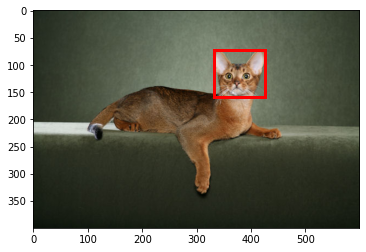

In [ ]:
#show data
def show_bbox(bbox_array,color = "red"):
    bbox = np.array(bbox_array)
    return Rectangle(bbox[0:2],width=bbox[2]-bbox[0],height=bbox[3]-bbox[1],color=color,fill=False,lw=3)

def image_with_bbox(im,bbox):
    plt.imshow(im)
    plt.gca().add_patch(show_bbox(bbox))
    plt.show()

img_path = "/content/cats_dogs_dataset/train/Abyssinian_1.jpg"
label_plus_bbox = "/content/cats_dogs_dataset/train/Abyssinian_1.txt"
image = Image.open(img_path)
print(image.size)
with open(label_plus_bbox,"r") as f:
    label,x_min,y_min,x_max,y_max = map(int,f.readline().split())
  
bbox = [x_min,y_min,x_max,y_max]
image_with_bbox(image,bbox)

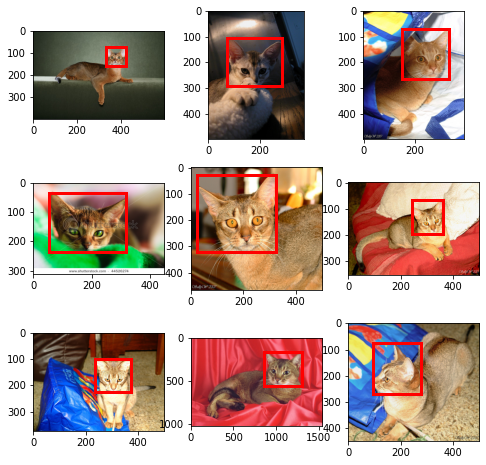

In [ ]:
array = sorted(os.listdir("/content/cats_dogs_dataset/train"))[:18]
def show_images(array:list):
  base_path = "/content/cats_dogs_dataset/train"
  num_image = 9
  fig = plt.figure(figsize=(8,8))
  for i in range(num_image):
    a = fig.add_subplot(3, 3, i + 1)
    image_path = array[i*2]
    label_plus_bbox = array[i*2 + 1]
    image = Image.open(os.path.join(base_path,image_path))
    with open(os.path.join(base_path,label_plus_bbox),"r") as f:
        label,x_min,y_min,x_max,y_max = map(int,f.readline().split())
    bbox = [x_min,y_min,x_max,y_max]
    plt.gca().add_patch(show_bbox(bbox))
    plt.imshow(image)
  plt.show()
show_images(array)

Ожидаемо, все изображения разного размера, необходимо привести к одному формату 256х256

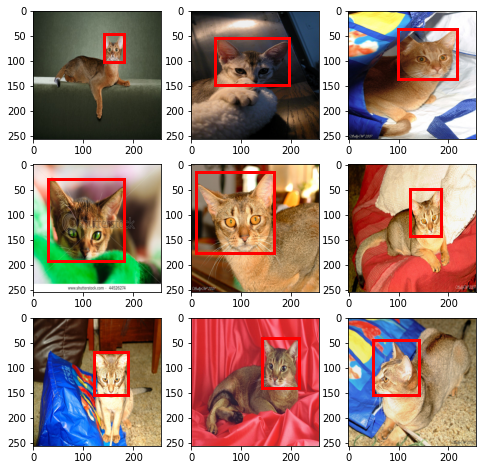

In [ ]:
def show_images(array:list):
  base_path = "/content/cats_dogs_dataset/train"
  num_image = 9
  fig = plt.figure(figsize=(8,8))
  for i in range(num_image):
    a = fig.add_subplot(3, 3, i + 1)
    image_path = array[i*2]
    label_plus_bbox = array[i*2 + 1]
    image = Image.open(os.path.join(base_path,image_path))
    x_size,y_size = image.size
    x_scale,y_scale = x_size/256,y_size/256
    image = image.resize(size=(256,256))
    with open(os.path.join(base_path,label_plus_bbox),"r") as f:
      label,x_min,y_min,x_max,y_max = map(int,f.readline().split())
    x_min = int(x_min / x_scale)
    y_min = int(y_min / y_scale)
    x_max = int(x_max / x_scale)
    y_max = int(y_max / y_scale)
    bbox = [x_min,y_min,x_max,y_max]
    plt.gca().add_patch(show_bbox(bbox))
    plt.imshow(image)
  plt.show()
show_images(array)


In [ ]:
path = "/content/cats_dogs_dataset/train"
print(len(os.listdir(path))/2)
path1 = "/content/cats_dogs_dataset/valid"
print(len(os.listdir(path1))/2)

2985.0
400.0


Попытка 1-без аугментации данных. 
Replace label 1,2 to 0,1

---



In [ ]:
class CreateDataset():
    def __init__(self,dataset_path,transforms=None, model_type = "resnet"):
        self.dataset_path = dataset_path
        self.transforms = transforms
     
        if model_type == "resnet":
            self.new_size = 256
        elif model_type == "inception":
            self.new_size= 299
        self.dset = sorted(os.listdir(self.dataset_path))
        self.dataset = self.create_data()
    def __len__(self):
        return int(len(os.listdir(self.dataset_path))/2)

    def bbox_scale(self,image_size):
        x_scale = np.round(image_size[0]/self.new_size,2)
        y_scale = np.round(image_size[1]/self.new_size,2)
        return x_scale, y_scale

    def create_data(self):
        _ = []
        for i in range(self.__len__()):
            current_idx = i*2
            image = Image.open(os.path.join(self.dataset_path,self.dset[current_idx]))
            x_scale,y_scale = self.bbox_scale(image.size)
            image = image.resize((self.new_size,self.new_size))
            label_plus_bbox_path = os.path.join(self.dataset_path,self.dset[current_idx + 1])
            with open(label_plus_bbox_path,"r") as f:
                label,x_min,y_min,x_max,y_max = list(map(int,f.readline().split()))
                x_min = int(x_min / x_scale)
                y_min = int(y_min / y_scale)
                x_max = int(x_max / x_scale)
                y_max = int(y_max / y_scale)
            bbox = torch.Tensor([x_min,y_min,x_max,y_max])
            _.append((image,label-1,bbox))
            
        return _

    def __getitem__(self, idx):
        if transforms == None:
            x = np.array(self.dataset[idx][0])
        else:
            x = self.transforms(self.dataset[idx][0])
        y_class = self.dataset[idx][1]
        y_bb = self.dataset[idx][2]
        return x, y_class, y_bb
train_test_transform = transforms.Compose([transforms.ToTensor()])

path_train = "/content/cats_dogs_dataset/train"
path_val  = "/content/cats_dogs_dataset/valid"
train = CreateDataset(path_train,train_test_transform)
val = CreateDataset(path_val,train_test_transform)

In [ ]:
train_dataset, test_dataset = train_test_split(train, test_size = 0.20, shuffle =True,random_state=42)
print(f"Размер тренировочного датасета {len(train_dataset)} изображений")
print(f"Размер тестового датасета {len(test_dataset)} изображений")
print(f"Размер валидационного датасета {len(val)} изображений")

Размер тренировочного датасета 2388 изображений
Размер тестового датасета 597 изображений
Размер валидационного датасета 400 изображений


In [ ]:
for index, data in enumerate(test_dataset):
    if not data[0].shape == torch.Size([3,256,256]):
      test_dataset.pop(index)
      print("Done!")


Done!


In [ ]:
print(f"Размер тренировочного датасета {len(train_dataset)} изображений")
print(f"Размер тестового датасета {len(test_dataset)} изображений")
print(f"Размер валидационного датасета {len(val)} изображений")

Размер тренировочного датасета 2388 изображений
Размер тестового датасета 596 изображений
Размер валидационного датасета 400 изображений


In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size = 32,
                          shuffle=True)

test_loader = DataLoader(test_dataset,
                          batch_size = 32,
                          shuffle = True) 

val_loader = DataLoader(val,
                          batch_size = 16,
                          shuffle = True)

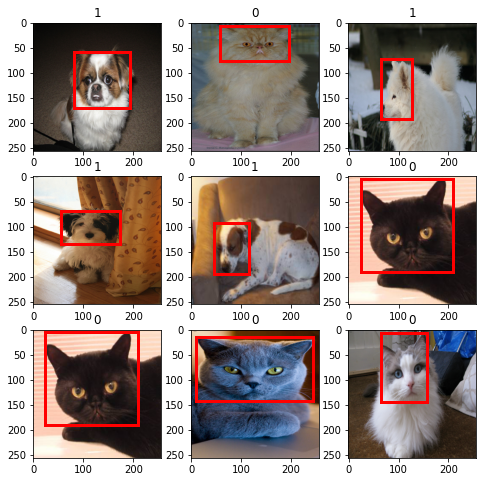

In [ ]:
def show_processed_images(loader):
    num_image = 9
    fig = plt.figure(figsize=(8,8))
    random_index = np.random.randint(0, len(loader),size=9)
    for i in range(num_image):
        a = fig.add_subplot(3, 3, i + 1)
        image, label, bbox = loader.dataset[random_index[i]]
        image = transforms.ToPILImage(mode='RGB')(image)
        plt.gca().add_patch(show_bbox(bbox))
        plt.imshow(image)
        a.set_title(f"{label}")
    plt.show()
show_processed_images(train_loader)

In [ ]:
class First_model(nn.Module):
    def __init__(self):
        super(First_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:-1] #last layer - AdaptiveAvgPool2d(output_size=(1, 1)) 
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 1),nn.Sigmoid())
        self.bb_reg = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512,4))
        
    def forward(self, x):
        x = x.to(device)
        x = self.features(x)
        x = x.view(x.shape[0],-1)
        return self.classifier(x), self.bb_reg(x)
        

In [ ]:
model = First_model().to(device)
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [ ]:
def save_model(model,acc,path):
    if not(os.path.exists(path)):
        os.mkdir(path)
    torch.save(model.state_dict(),os.path.join(path,str(acc)+".pth"))
    

def val_metrics(model, class_loss, bbox_loss, test_dl, C=1000, const = -1,flag = False):
    model.eval()
    total, sum_loss, correct = 0, 0, 0 
    for x, y_class, y_bb in test_dl:
        batch = y_class.shape[0]
        x = x.to(device)
        y_class = y_class.to(device).reshape(-1,1).float()
        y_bb = y_bb.to(device)

        with torch.no_grad():
            out_class, out_bb = model(x)
            loss_class = class_loss(out_class, y_class)
            loss_bb = bbox_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C

        out_class = torch.round(out_class)
        correct += (y_class == out_class).sum().float() 
        sum_loss += loss.item()
        total += batch
    val_correct = correct/total
    if val_correct >= const and flag:
        save_model(model,val_correct,path = "saved_models")
        const = val_correct 
    return sum_loss/total, val_correct

def train_epocs(model, optimizer,class_loss, bbox_loss, train_dl, test_dl, epochs=10,C=1000,flag = False):
    hist = []
    for i in range(epochs):
        model.train()
        total, sum_loss, correct = 0, 0, 0 
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.to(device)
            y_class = y_class.to(device).reshape(-1,1).float()
            y_bb = y_bb.to(device)

            out_class, out_bb = model(x) #predict class and bbox
            
            loss_class = class_loss(out_class, y_class)
            loss_bb = bbox_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            out_class = torch.round(out_class)#round sigmoid output
            total += batch
            sum_loss += loss.item() 
            correct += (y_class == out_class).sum().float() 
        train_loss = sum_loss/total
        train_acc = correct/total
        val_loss, val_acc = val_metrics(model,class_loss, bbox_loss, test_dl, C, flag=flag)
        hist.append((train_loss,val_loss,train_acc,val_acc))
        print("train_loss %.3f train_acc %.3f val_loss %.3f val_acc %.3f" % (train_loss, train_acc, val_loss, val_acc))
    return hist

def show_graph(hist):
    t_loss,v_loss,t_acc,v_acc = [], [], [], []
    for train_loss,val_loss,train_acc,val_acc in hist:
        t_loss.append(train_loss)
        v_loss.append(val_loss)
        t_acc.append(train_acc)
        v_acc.append(val_acc)

    fig = plt.figure(figsize=(16,16))
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

    ax1.plot(t_loss, label="train_loss")
    ax1.plot(v_loss, label="val_loss")
    ax1.legend(loc=2)
    ax2.plot(t_acc, label="train_acc")
    ax2.plot(v_acc, label="val_acc")
    ax2.legend(loc=2)
    plt.show()

train_loss 61.063 train_acc 0.677 val_loss 42.099 val_acc 0.669
train_loss 20.493 train_acc 0.678 val_loss 8.293 val_acc 0.669
train_loss 5.313 train_acc 0.683 val_loss 6.996 val_acc 0.663
train_loss 4.845 train_acc 0.675 val_loss 5.503 val_acc 0.664
train_loss 4.364 train_acc 0.691 val_loss 4.899 val_acc 0.656
train_loss 3.969 train_acc 0.701 val_loss 4.596 val_acc 0.668
train_loss 3.547 train_acc 0.691 val_loss 5.137 val_acc 0.560
train_loss 3.079 train_acc 0.714 val_loss 4.050 val_acc 0.671
train_loss 2.763 train_acc 0.701 val_loss 4.427 val_acc 0.636
train_loss 2.337 train_acc 0.709 val_loss 3.256 val_acc 0.659


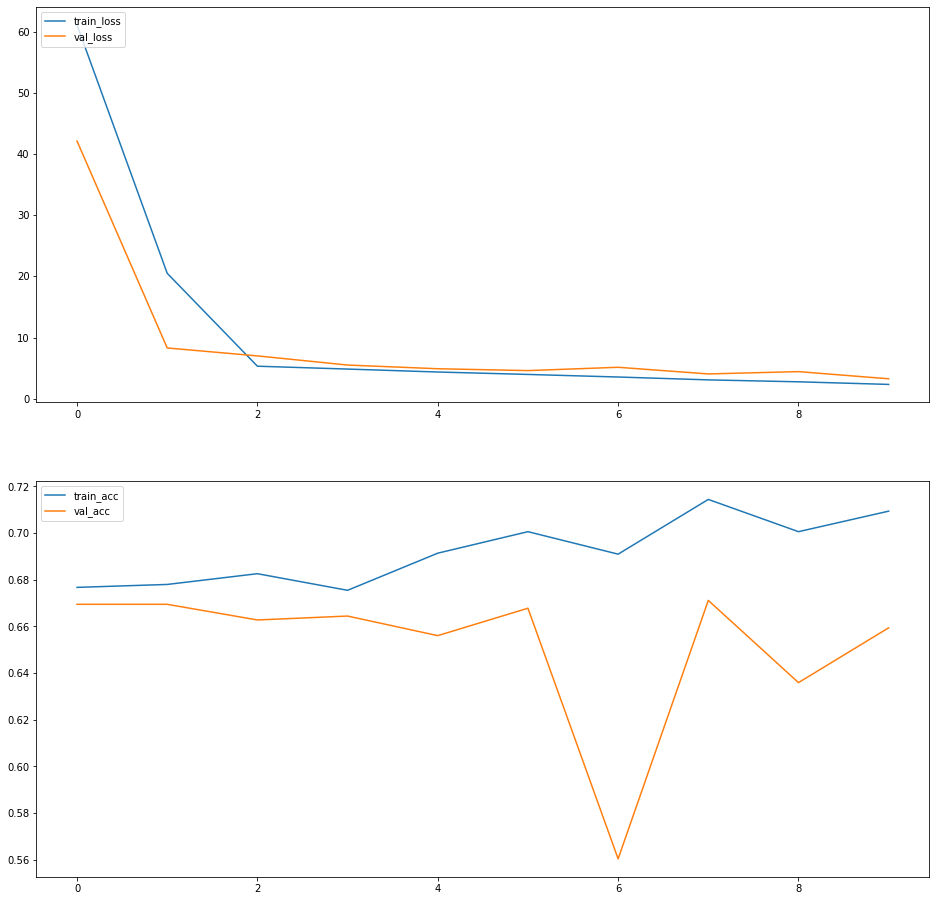

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
class_loss = nn.BCELoss()
bbox_loss = F.mse_loss
history = train_epocs(model, optimizer,class_loss, bbox_loss, train_loader, test_loader,C = 1000, epochs=10)
show_graph(history)


train_loss 0.076 train_acc 0.710 val_loss 0.080 val_acc 0.700
train_loss 0.070 train_acc 0.735 val_loss 0.078 val_acc 0.721
train_loss 0.067 train_acc 0.764 val_loss 0.074 val_acc 0.758
train_loss 0.064 train_acc 0.798 val_loss 0.072 val_acc 0.777
train_loss 0.061 train_acc 0.811 val_loss 0.070 val_acc 0.812
train_loss 0.059 train_acc 0.845 val_loss 0.069 val_acc 0.802
train_loss 0.055 train_acc 0.862 val_loss 0.066 val_acc 0.832
train_loss 0.053 train_acc 0.889 val_loss 0.066 val_acc 0.822
train_loss 0.050 train_acc 0.914 val_loss 0.066 val_acc 0.862
train_loss 0.048 train_acc 0.934 val_loss 0.067 val_acc 0.827
train_loss 0.044 train_acc 0.956 val_loss 0.070 val_acc 0.794
train_loss 0.042 train_acc 0.966 val_loss 0.069 val_acc 0.810
train_loss 0.040 train_acc 0.973 val_loss 0.066 val_acc 0.846
train_loss 0.039 train_acc 0.985 val_loss 0.068 val_acc 0.851
train_loss 0.038 train_acc 0.983 val_loss 0.073 val_acc 0.804
train_loss 0.036 train_acc 0.985 val_loss 0.069 val_acc 0.837
train_lo

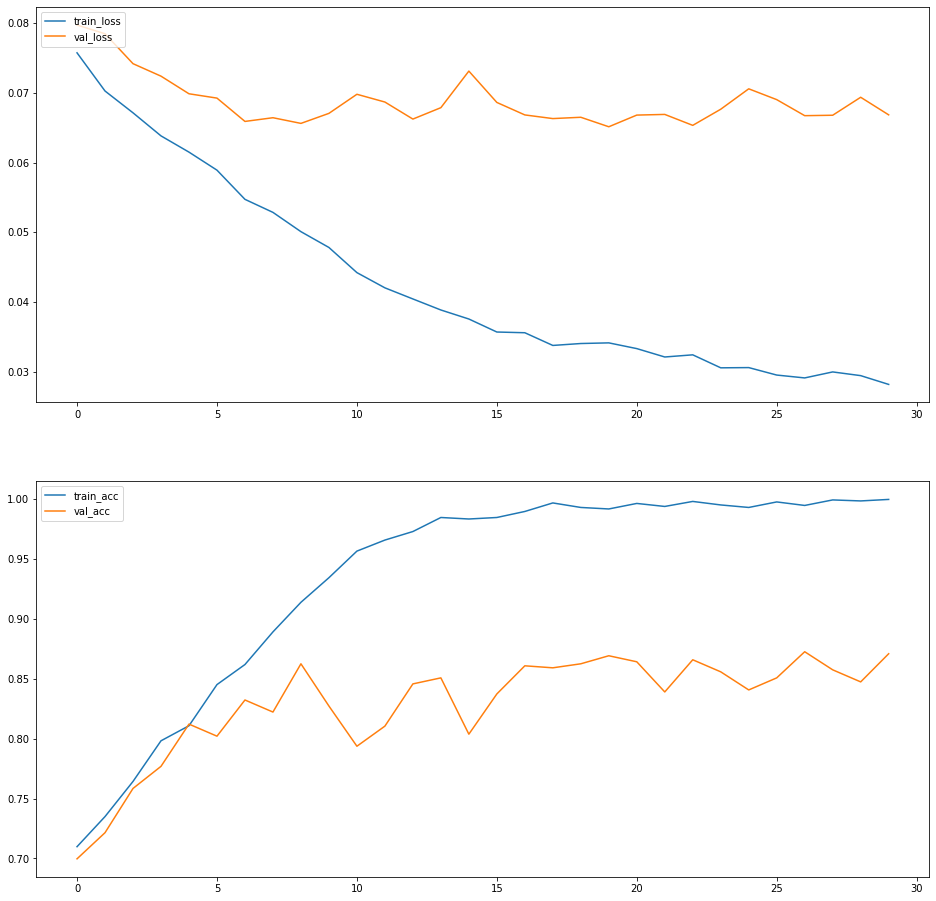

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
bbox_loss = F.l1_loss
history = train_epocs(model, optimizer,class_loss, bbox_loss, train_loader, test_loader,C = 1000, epochs=30)
show_graph(history)

train_loss 0.060 train_acc 0.999 val_loss 0.126 val_acc 0.846
train_loss 0.062 train_acc 0.996 val_loss 0.125 val_acc 0.829
train_loss 0.059 train_acc 0.997 val_loss 0.117 val_acc 0.864
train_loss 0.059 train_acc 0.998 val_loss 0.114 val_acc 0.857
train_loss 0.058 train_acc 0.996 val_loss 0.117 val_acc 0.859
train_loss 0.056 train_acc 0.993 val_loss 0.121 val_acc 0.844
train_loss 0.058 train_acc 0.996 val_loss 0.116 val_acc 0.866
train_loss 0.055 train_acc 0.998 val_loss 0.116 val_acc 0.857
train_loss 0.055 train_acc 0.997 val_loss 0.115 val_acc 0.871
train_loss 0.055 train_acc 0.999 val_loss 0.115 val_acc 0.861
train_loss 0.052 train_acc 0.997 val_loss 0.117 val_acc 0.852
train_loss 0.054 train_acc 0.998 val_loss 0.114 val_acc 0.879
train_loss 0.054 train_acc 0.996 val_loss 0.118 val_acc 0.857
train_loss 0.053 train_acc 0.998 val_loss 0.115 val_acc 0.867
train_loss 0.053 train_acc 0.997 val_loss 0.112 val_acc 0.867
train_loss 0.052 train_acc 1.000 val_loss 0.119 val_acc 0.851
train_lo

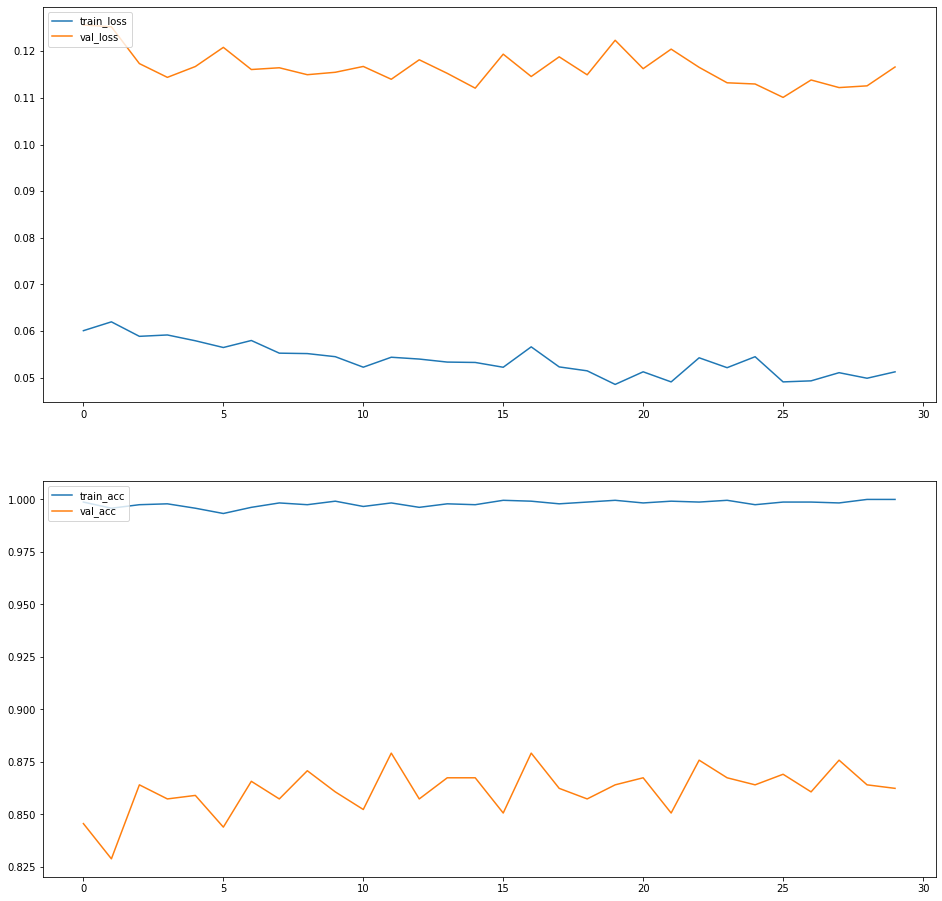

In [ ]:
history = train_epocs(model.to(device), optimizer,class_loss, bbox_loss, train_loader, test_loader,C = 500, epochs=30)
show_graph(history)

train_loss 0.024 train_acc 0.999 val_loss 0.065 val_acc 0.871
train_loss 0.025 train_acc 0.998 val_loss 0.065 val_acc 0.871
train_loss 0.023 train_acc 1.000 val_loss 0.065 val_acc 0.869
train_loss 0.024 train_acc 1.000 val_loss 0.065 val_acc 0.872
train_loss 0.023 train_acc 1.000 val_loss 0.065 val_acc 0.866
train_loss 0.023 train_acc 1.000 val_loss 0.064 val_acc 0.866
train_loss 0.026 train_acc 0.998 val_loss 0.064 val_acc 0.874
train_loss 0.024 train_acc 1.000 val_loss 0.064 val_acc 0.871
train_loss 0.023 train_acc 1.000 val_loss 0.063 val_acc 0.874
train_loss 0.023 train_acc 0.999 val_loss 0.064 val_acc 0.869


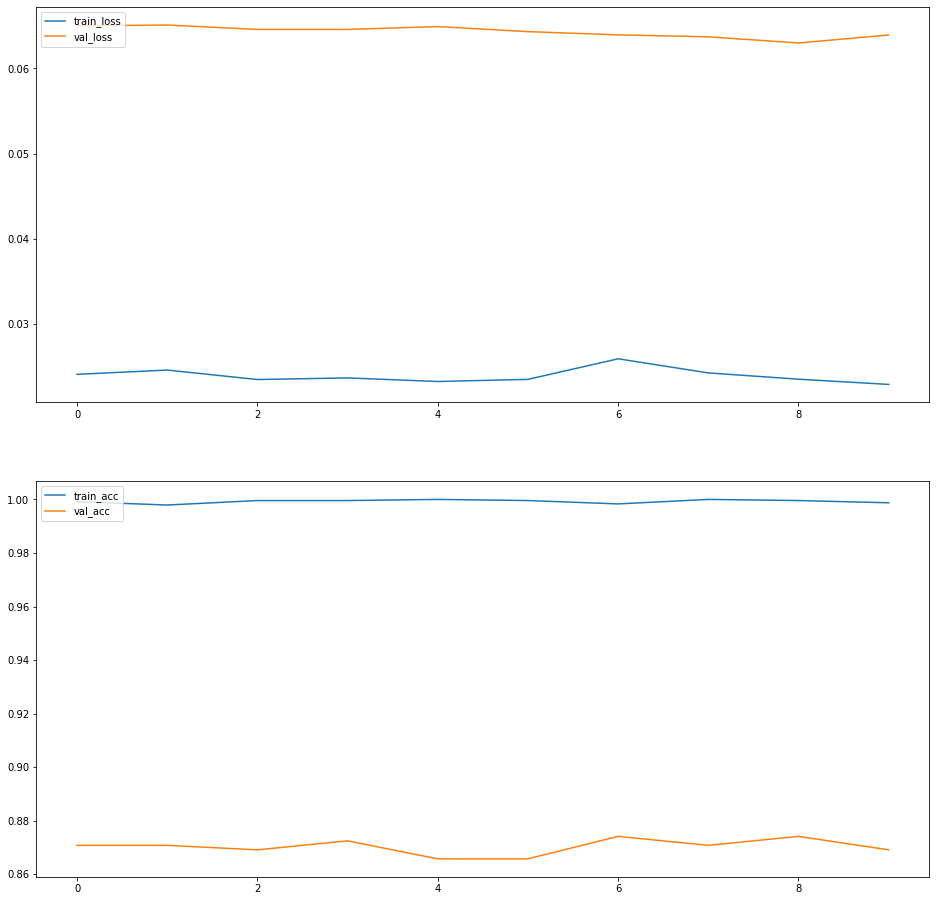

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
history = train_epocs(model, optimizer,class_loss, bbox_loss, train_loader, test_loader,C = 1000, epochs=10, flag = True)
show_graph(history)

In [ ]:
from google.colab import files
uploaded = files.upload()

TypeError: ignored

In [ ]:
Dmodel = First_model()
Dmodel.load_state_dict(torch.load("/content/tensor(0.8742, device='cuda_0').pth"))
Dmodel = Dmodel.to(device).eval()

In [ ]:
def IOU(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

def show_predict(model,loader):
  num_image = 9
  convert_label = {0:'cat',1:"dog"}
  fig = plt.figure(figsize=(16,16))
  random_index = np.random.randint(0, len(loader.dataset),size=9)
  for i in range(num_image):
    # part of predict neural network
    a = fig.add_subplot(3, 3, i + 1)
    image, label, bbox1 = loader.dataset[random_index[i]]
    image_for_graph = copy.deepcopy(image)
    image = image.unsqueeze(0)
    pred,bbox2 = model(image)
    predict = torch.round(pred)
    bbox2 = bbox2.detach().numpy()
    #part of visualization
    image_for_graph = transforms.ToPILImage()(image_for_graph)
    plt.gca().add_patch(show_bbox(bbox2[0]))
    plt.imshow(image_for_graph)
    a.set_title("IOU:%.3f  Predict: %s" %(IOU(bbox1,bbox2[0]),convert_label[int(predict)]))

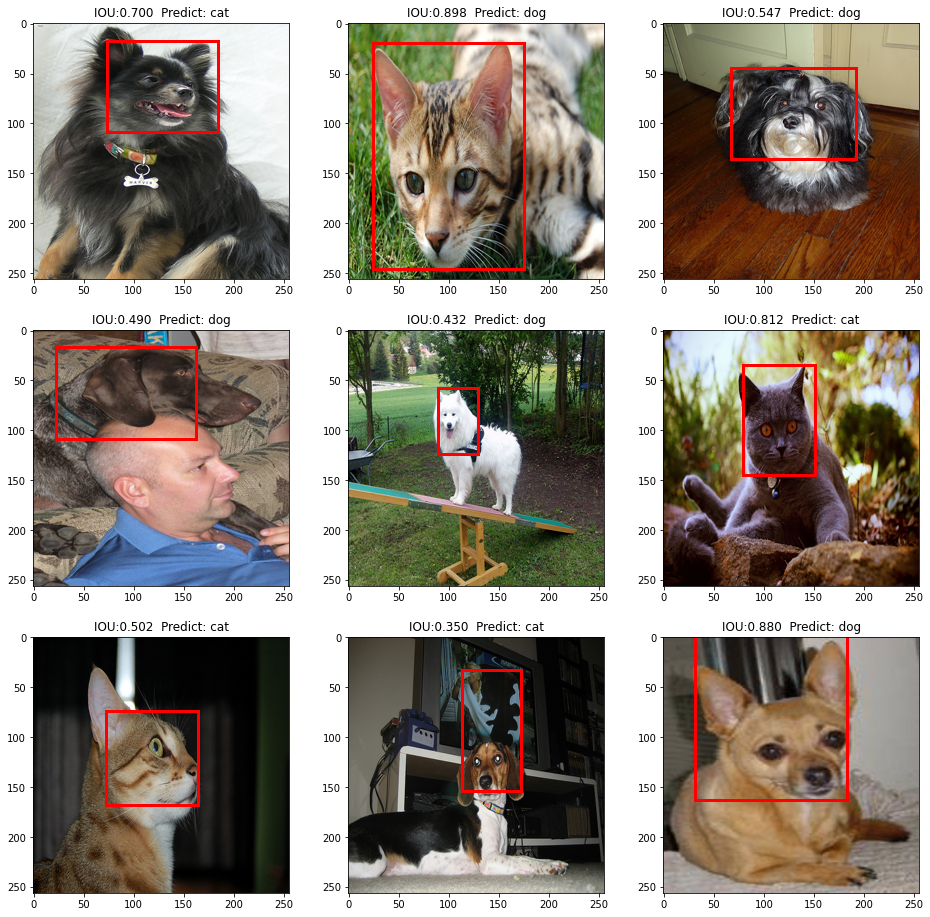

In [ ]:
device = "cpu"
show_predict(Dmodel.to(device),val_loader)

Расчет метрик качества ТЗ

In [ ]:
import time
def model_accuracy(model,data_loader):
    model.eval()
    total, correct = 0, 0
    for x, y_class, y_bb in data_loader:
        batch = y_class.shape[0]
        x = x.to(device)
        y_class = y_class.to(device).reshape(-1,1).float()
        with torch.no_grad():
            out_class, out_bb = model(x)
        out_class = torch.round(out_class)
        correct += (y_class == out_class).sum().float() 
        total += batch
    accuracy = correct/total
    return accuracy


def mIOU(model,loader):
    model.eval()
    score = 0
    with torch.no_grad():
        for image, label,bbox in loader:
            image = image.to(device)
            _, bbox_predict = model(image)
            for real_bb,pred_bb in zip(*[bbox,bbox_predict]):
                score += IOU(real_bb, pred_bb) 
    return np.array(score)/float(len(val))

def calculate_ans(model,val_loader,calc_acc,calc_mIOU):
    device = torch.device('cpu')
    model.to(device)
    random_image = np.random.randint(0, len(val_loader),size = 1)
    image, label, bbox1 = val_loader.dataset[random_image[0]]
    start = time.clock()
    y_class, bbox = model(image.unsqueeze(0).to(device))
    end = time.clock()
    classifier_acc = calc_acc(model,val_loader)
    miou = calc_mIOU(model,val_loader)
    print("*"*100)
    print("miou: %.3f classification accuracy: %.3f, work speed %.3f len valloader: %d"
           %(100*miou,100*classifier_acc,end-start,len(val)))
    print("*"*100)
calculate_ans(Dmodel,val_loader,model_accuracy,mIOU)

В этой попытке:
1.   более глубокая сеть InceptionV3
2.   Аугментация данных
3.   Координаты bbox переведены в относительные





In [ ]:
cats, dogs = 0,0
base_path = "/content/cats_dogs_dataset/train"
for item in sorted(os.listdir(base_path)):
    if item.endswith(".txt"):
        with open(os.path.join(base_path,item),"r") as f:
            label,x_min,y_min,x_max,y_max = map(int,f.readline().split())  
            if label == 1:
                cats+=1
            else:
                dogs+=1
print(f"Cats in train set:{cats}")
print(f"Dogs in train set:{dogs}")

Cats in train set:911
Dogs in train set:2074


In [ ]:
cats, dogs = [],[]
array = sorted(os.listdir("/content/cats_dogs_dataset/train"))
new_im_size = 299
for i in range(int(len(array)/2)):
    image = Image.open(os.path.join(base_path, array[i*2]))
    x_size,y_size = image.size
    x_scale,y_scale = x_size/new_im_size,y_size/new_im_size
    image = image.resize((299,299))
    image = np.array(image)
    label_plus_bbox = array[i*2 + 1]
    with open(os.path.join(base_path,label_plus_bbox),"r") as f:
        label,x_min,y_min,x_max,y_max = map(int,f.readline().split())
        label = label - 1
        x_min = int(x_min / x_scale)
        y_min = int(y_min / y_scale)
        x_max = int(x_max / x_scale)
        y_max = int(y_max / y_scale)
    bbox = [x_min,y_min,x_max,y_max]
    if image.shape == (299, 299, 3):
        if label == 1:
            cats.append([image,label,bbox])
        else:
            dogs.append([image,label,bbox])


In [ ]:
pip install imgaug

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
ia.seed(42)

In [ ]:
def increasedata(dataset,N):
    _ = []
    random_index = np.random.randint(0, len(dataset), 
                                     size = N - len(dataset))
    for i in random_index:
        _.append(dataset[i])
    return dataset + _
Icat = increasedata(cats,3000)
Idog = increasedata(dogs,3000)

In [ ]:
cotopes = Icat + Idog
train_dataset, test_dataset = train_test_split(cotopes, test_size = 0.25, shuffle =True,random_state=42)
print(f"Размер тренировочного датасета {len(train_dataset)} изображений")
print(f"Размер тестового датасета {len(test_dataset)} изображений")
#print(f"Размер валидационного датасета {len(val)} изображений")

Размер тренировочного датасета 4500 изображений
Размер тестового датасета 1500 изображений


In [ ]:
def im_augm(dataset,augm,im_size = (299,299)):
    augm_dataset = []
    for image,label,bbox in dataset:
        xmin, ymin, xmax, ymax = bbox
        bbs = BoundingBoxesOnImage([BoundingBox(xmin, ymin, xmax, ymax)
        ], shape = im_size)
        image, bbs_aug = augm(image=image, bounding_boxes=bbs)
        bbs_aug = bbs_aug.bounding_boxes[0]
        xmin,ymin,xmax,ymax = bbs_aug.x1, bbs_aug.y1, bbs_aug.x2, bbs_aug.y2
        xmin = xmin if xmin >= 0 else 0
        ymin = ymin if ymin >= 0 else 0
        xmax = xmax if xmax < 299 else 299
        ymax = ymax if ymax < 299 else 299
        bbox = [xmin,ymin,xmax,ymax]
        augm_dataset.append([image,label,bbox])    
    return augm_dataset     

augmentation = iaa.Sequential([
    iaa.Fliplr(0.5), 
    iaa.Crop(percent=(0.1, 0.1)), 
    iaa.Affine(
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-10, 10),
        shear=(-8, 8),
        scale = (np.round(random.uniform(0.8,1),2),
                 np.round(random.uniform(0.8,1),2))
    )
], random_order=True)
train = im_augm(train_dataset, augmentation)

In [ ]:
checktrain = copy.deepcopy(train)
checktest = copy.deepcopy(test_dataset)

In [ ]:
def image_transform(dataset, mode, transform):
    if mode == "train":
        for i in range(len(dataset)):
            dataset[i][0] = transform(dataset[i][0])
            dataset[i][2] = torch.tensor(dataset[i][2])/299
    if mode == "test":
        for i in range(len(dataset)):
            image = dataset[i][0]
            if type(image) == torch.Tensor:
                pass
            else:
                dataset[i][0] = Image.fromarray(dataset[i][0])
                dataset[i][0] = transform(dataset[i][0])
                dataset[i][2] = torch.tensor(dataset[i][2])/299
            

train_transform = transforms.Compose([transforms.ToTensor()])
train_set = image_transform(checktrain,"train",train_transform)
test_set = image_transform(checktest,"test",train_transform)

In [ ]:
train_loader = DataLoader(checktrain,
                          batch_size = 32,
                          shuffle=True)

test_loader = DataLoader(checktest,
                          batch_size = 32,
                          shuffle = True) 

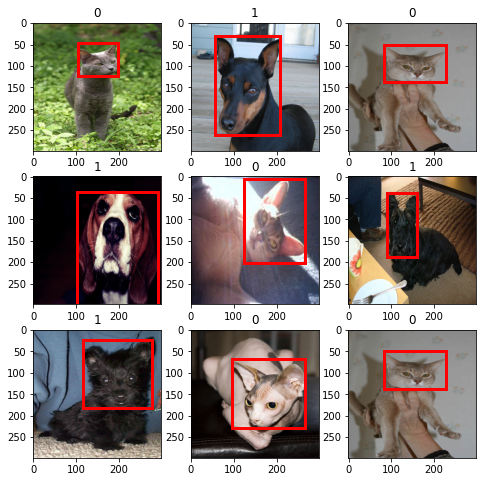

In [ ]:
def show_processed_images(loader):
    num_image = 9
    fig = plt.figure(figsize=(8,8))
    random_index = np.random.randint(0, len(loader),size=9)
    for i in range(num_image):
        a = fig.add_subplot(3, 3, i + 1)
        image, label, bbox = loader.dataset[random_index[i]]
        bbox = 299 * bbox
        image = transforms.ToPILImage(mode='RGB')(image)
        plt.gca().add_patch(show_bbox(bbox))
        plt.imshow(image)
        a.set_title(f"{label}")
    plt.show()
show_processed_images(test_loader)

In [ ]:
class Second_model(nn.Module):
    def __init__(self):
        super(Second_model, self).__init__()
        inception = models.inception_v3(pretrained=True)
        layers = list(inception.children())
        self.change_fc = nn.Sequential(
                              nn.Linear(2048, 1024),
                              nn.BatchNorm1d(1024),
                              nn.ReLU(),
                              nn.Linear(1024,256),
                              nn.BatchNorm1d(256),
                              nn.ReLU(),
                              nn.Linear(256,64),
                              nn.BatchNorm1d(64),
                              nn.ReLU())
        
        self.first_layers = nn.Sequential(*layers[:15])
        #реализовать собственный InceptionAux пришлось по той причине, что
        #для уменьшения размерности используется F.avg_pool2d, но в forward,
        #поэтому, при изменении модуля размерность тензора отличется.
        #https://chsasank.github.io/vision/_modules/torchvision/models/inception.html
        self.my_aux = nn.Sequential(
                                    nn.AvgPool2d(kernel_size=5, stride=3),
                                    nn.Conv2d(in_channels=768, out_channels = 128,kernel_size=1),
                                    nn.BatchNorm2d(num_features=128),
                                    nn.Conv2d(in_channels= 128, out_channels=768,kernel_size=5))
        self.aux = nn.Sequential(
                                    nn.Linear(768,256),
                                    nn.BatchNorm1d(256),
                                    nn.ReLU(),
                                    nn.Linear(256,64),
                                    nn.BatchNorm1d(64),
                                    nn.ReLU())
        
        self.cls = nn.Sequential(nn.Linear(64, 1),nn.Sigmoid())
        self.reg =  nn.Sequential(nn.Linear(64, 4),nn.Sigmoid())
        self.other_layers = nn.Sequential(*layers[16:-1])

    def forward(self, x):
        x = x.to(device)
        x = self.first_layers(x)
        if self.training:
            x1 = self.my_aux(x)
            x1 = x1.view(x1.shape[0],-1)
            x1 = self.aux(x1)
        x = self.other_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.change_fc(x)
        if self.training:
            aux_out = self.cls(x1),self.reg(x1)
            model_out = self.cls(x),self.reg(x)
            return model_out, aux_out
        model_out = self.cls(x), self.reg(x)
        return model_out


In [ ]:
model = Second_model().to(device)

In [ ]:
def save_model(model,acc,path):
    if not(os.path.exists(path)):
        os.mkdir(path)
    torch.save(model.state_dict(),os.path.join(path,str(acc)+".pth"))
    
def val_metrics(model, class_loss, bbox_loss, test_dl, C=1000, const = -1,flag = False):
    model.eval()
    total, sum_loss, correct = 0, 0, 0 
    print_bbox_loss = 0
    for x, y_class, y_bb in test_dl:
        batch = y_class.shape[0]
        x = x.to(device).float()
        y_class = y_class.to(device).reshape(-1,1).float()
        y_bb = y_bb.to(device).float()

        with torch.no_grad():
            out_class, out_bb = model(x)
            loss_class = class_loss(out_class, y_class)
            loss_bb = bbox_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C

        out_class = torch.round(out_class)
        correct += (y_class == out_class).sum().float() 
        sum_loss += loss.item()
        print_bbox_loss += loss_bb.item()
        total += batch
    val_correct = correct/total
    if val_correct >= const and flag:
        save_model(model,val_correct,path = "saved_models")
        const = val_correct 
    print("Bbox loss value on test epoch:{:.5f}".format(print_bbox_loss))
    return sum_loss/total, val_correct

def train_epocs(model, optimizer,class_loss, bbox_loss, train_dl, test_dl, epochs=10,C=1000,flag = False):
    hist = []
    for i in range(epochs):
        model.train()
        total, sum_loss, correct = 0, 0, 0 
        print_bbox_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.to(device)
            y_class = y_class.to(device).reshape(-1,1).float()
            y_bb = y_bb.to(device).float()

            out_model , out_aux = model(x) #predict class and bbox
            model_cls, model_reg = out_model
            aux_cls, aux_reg = out_aux

            # model loss
            m_loss_class = class_loss(model_cls, y_class)
            m_loss_bb = bbox_loss(model_reg, y_bb, reduction="none").sum(1)
            m_loss_bb = m_loss_bb.sum()
            m_loss = m_loss_class + m_loss_bb/C

            #auxloss
            a_loss_class = class_loss(aux_cls, y_class)
            a_loss_bb = bbox_loss(aux_reg, y_bb, reduction="none").sum(1)
            a_loss_bb = a_loss_bb.sum()
            a_loss = a_loss_class + a_loss_bb/C

            loss = (m_loss + 0.7 * a_loss).float()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            out_class = torch.round(model_cls)#round sigmoid output
            total += batch
            print_bbox_loss += m_loss_bb.item() + a_loss_bb.item()
            sum_loss += loss.item() 
            correct += (y_class == out_class).sum().float() 
        train_loss = sum_loss/total
        train_acc = correct/total
        print(f"Epoch number: {i+1}")
        print("Bbox loss value on train epoch:{:.5f}".format(print_bbox_loss))
        val_loss, val_acc = val_metrics(model,class_loss, bbox_loss, test_dl, C, flag=flag)
        hist.append((train_loss,val_loss,train_acc,val_acc))
        print("train_loss %.3f train_acc %.3f val_loss %.3f val_acc %.3f\n" % (train_loss, train_acc, val_loss, val_acc))
    return hist

def show_graph(hist):
    t_loss,v_loss,t_acc,v_acc = [], [], [], []
    for train_loss,val_loss,train_acc,val_acc in hist:
        t_loss.append(train_loss)
        v_loss.append(val_loss)
        t_acc.append(train_acc)
        v_acc.append(val_acc)

    fig = plt.figure(figsize=(16,16))
    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

    ax1.plot(t_loss, label="train_loss")
    ax1.plot(v_loss, label="val_loss")
    ax1.legend(loc=2)
    ax2.plot(t_acc, label="train_acc")
    ax2.plot(v_acc, label="val_acc")
    ax2.legend(loc=2)
    plt.show()

Epoch number: 1
Bbox loss value on train epoch:945.71210
train_loss 0.227 train_acc 0.861 val_loss 0.028 val_acc 0.987

Epoch number: 2
Bbox loss value on train epoch:191.24400
train_loss 0.051 train_acc 0.981 val_loss 0.013 val_acc 0.994

Epoch number: 3
Bbox loss value on train epoch:114.17052
train_loss 0.030 train_acc 0.991 val_loss 0.011 val_acc 0.997

Epoch number: 4
Bbox loss value on train epoch:86.53551
train_loss 0.022 train_acc 0.996 val_loss 0.008 val_acc 0.997

Epoch number: 5
Bbox loss value on train epoch:76.44775
train_loss 0.019 train_acc 0.996 val_loss 0.008 val_acc 0.999

Epoch number: 6
Bbox loss value on train epoch:69.56910
train_loss 0.018 train_acc 0.994 val_loss 0.006 val_acc 0.997

Epoch number: 7
Bbox loss value on train epoch:67.25321
train_loss 0.017 train_acc 0.997 val_loss 0.007 val_acc 0.997

Epoch number: 8
Bbox loss value on train epoch:63.32963
train_loss 0.015 train_acc 0.994 val_loss 0.008 val_acc 0.983

Epoch number: 9
Bbox loss value on train epoc

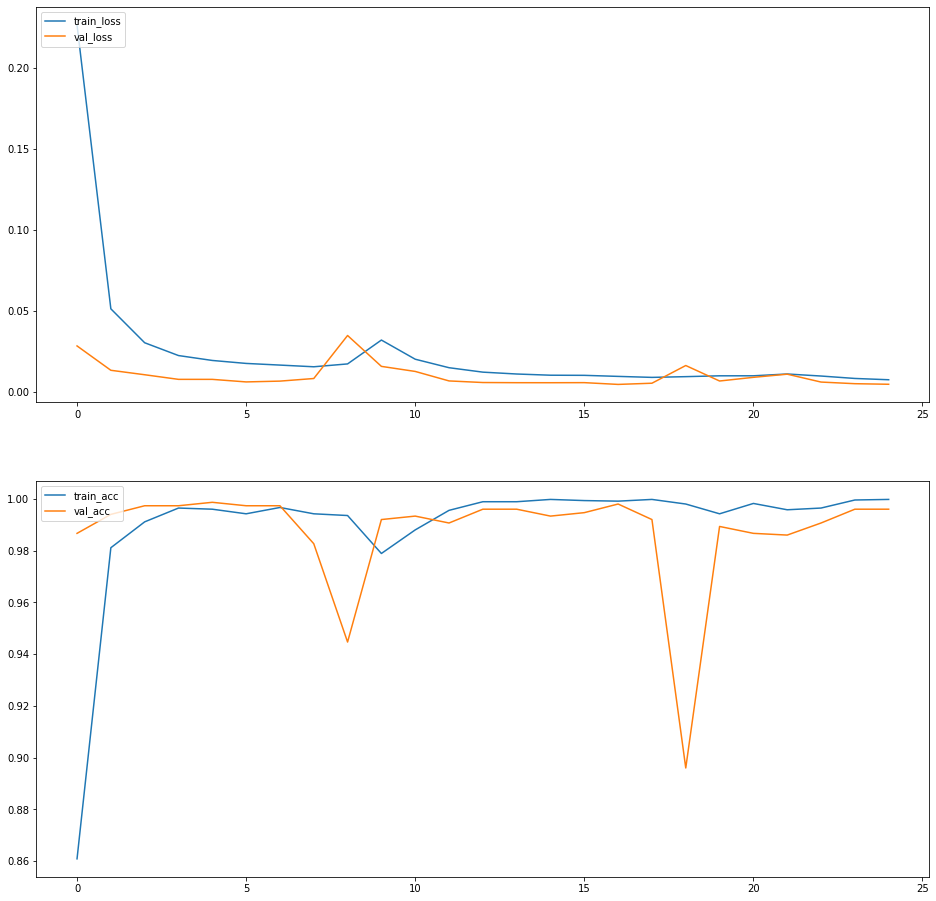

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
class_loss = nn.BCELoss()
bbox_loss = F.mse_loss
history = train_epocs(model.to(device), optimizer,class_loss, bbox_loss, train_loader, test_loader,C = 0.9, epochs=25)
show_graph(history)

In [ ]:
torch.save(model.state_dict(),"inceptionBBox.pth")

Epoch number: 1
Bbox loss value on train epoch:27.85705
Bbox loss value on test epoch:4.83510
train_loss 0.007 train_acc 1.000 val_loss 0.005 val_acc 0.996

Epoch number: 2
Bbox loss value on train epoch:25.77355
Bbox loss value on test epoch:4.90810
train_loss 0.006 train_acc 1.000 val_loss 0.005 val_acc 0.996

Epoch number: 3
Bbox loss value on train epoch:25.72094
Bbox loss value on test epoch:4.44397
train_loss 0.006 train_acc 1.000 val_loss 0.004 val_acc 0.996

Epoch number: 4
Bbox loss value on train epoch:22.41786
Bbox loss value on test epoch:4.92718
train_loss 0.006 train_acc 1.000 val_loss 0.005 val_acc 0.995

Epoch number: 5
Bbox loss value on train epoch:23.48176
Bbox loss value on test epoch:4.93332
train_loss 0.006 train_acc 1.000 val_loss 0.005 val_acc 0.996

Epoch number: 6
Bbox loss value on train epoch:21.80585
Bbox loss value on test epoch:4.76052
train_loss 0.005 train_acc 1.000 val_loss 0.005 val_acc 0.996

Epoch number: 7
Bbox loss value on train epoch:21.97477
Bb

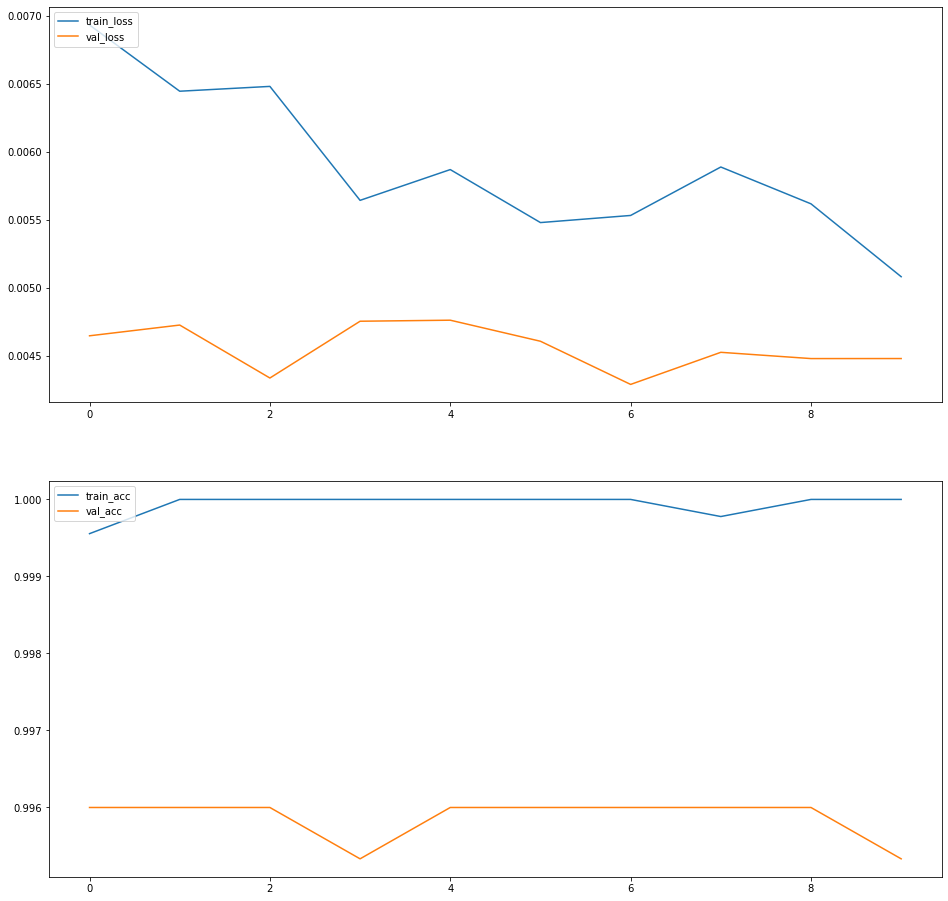

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
class_loss = nn.BCELoss()
bbox_loss = F.mse_loss
history = train_epocs(model.to(device), optimizer,class_loss, bbox_loss, train_loader, test_loader,C = 0.8, epochs=10,flag=True)
show_graph(history)

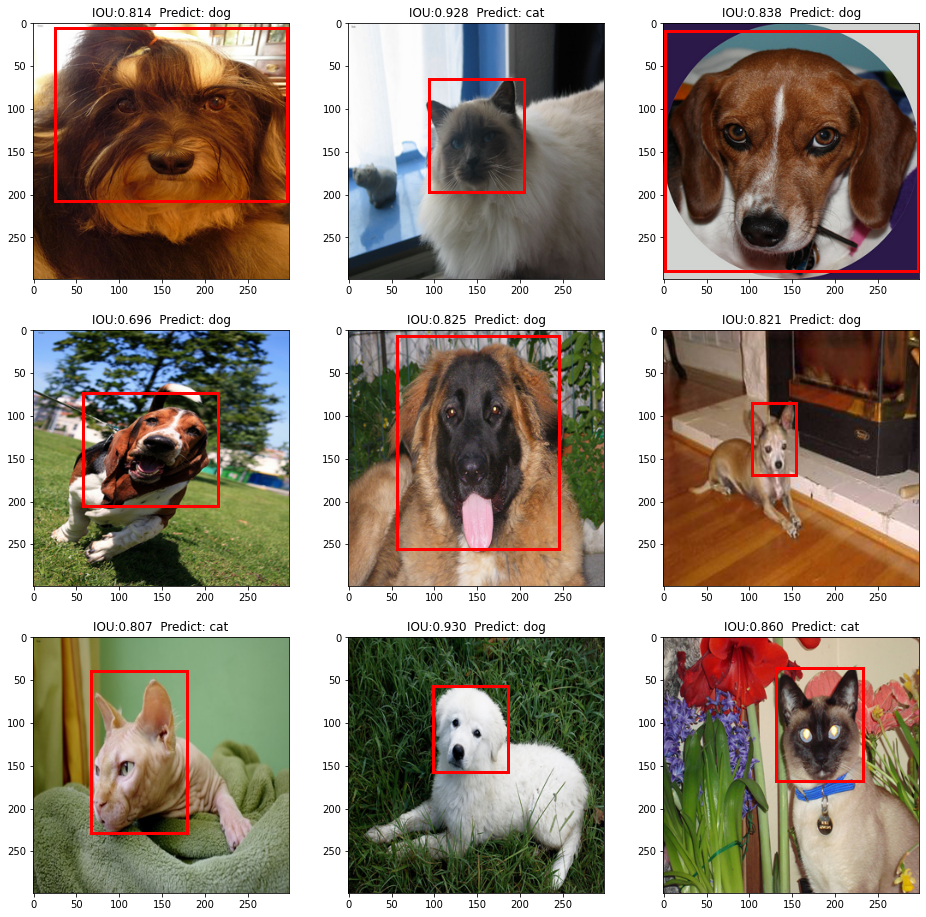

In [ ]:
def IOU(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

def show_predict(model,loader):
  model.eval()
  num_image = 9
  convert_label = {0:'cat',1:"dog"}
  fig = plt.figure(figsize=(16,16))
  random_index = np.random.randint(0, len(loader.dataset),size=9)
  for i in range(num_image):
    # part of predict neural network
    a = fig.add_subplot(3, 3, i + 1)
    image, label, bbox1 = loader.dataset[random_index[i]]
    bbox1 = bbox1 *299
    image_for_graph = copy.deepcopy(image)
    image = image.unsqueeze(0)
    pred, bbox2 = model(image.float())
    predict = torch.round(pred)
    bbox2 = bbox2.detach().numpy()*299
    #part of visualization
    image_for_graph = transforms.ToPILImage()(image_for_graph)
    plt.gca().add_patch(show_bbox(bbox2[0]))
    plt.imshow(image_for_graph)
    a.set_title("IOU:%.3f  Predict: %s" %(IOU(bbox1,bbox2[0]),convert_label[int(predict)]))
device = "cpu"
show_predict(model.to(device),test_loader)

In [ ]:
val = CreateDataset(path_val,train_test_transform,"inception")
val_loader = DataLoader(val,
                          batch_size = 16,
                          shuffle = True)

In [ ]:
model.load_state_dict(torch.load("/content/saved_models/tensor(0.9960, device='cuda:0').pth"))
Dmodel = model.to(device).eval()

In [ ]:
def mIOU_(model,loader):
    model.eval()
    score = 0
    with torch.no_grad():
        for image, label,bbox in loader:
            bbox = bbox 
            image = image.to(device)
            _, bbox_predict = model(image)
            bbox_predict = bbox_predict 
            for real_bb,pred_bb in zip(*[bbox,bbox_predict]):
                pred_bb = pred_bb * 299
                score += IOU(real_bb, pred_bb) 
    return np.array(score)/float(len(val))


device = "cpu"
calculate_ans(Dmodel.to(device),val_loader,model_accuracy,mIOU_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


****************************************************************************************************
miou: 79.842 classification accuracy: 99.250, work speed 0.320 len valloader: 400
****************************************************************************************************


Скорее всего потенциал для обучения сети еще не исчерпан. Как видно значение функции потерь для bbox (MSE) стабильно снижаются, можно сделать вывод, что результаты можно улучшить.

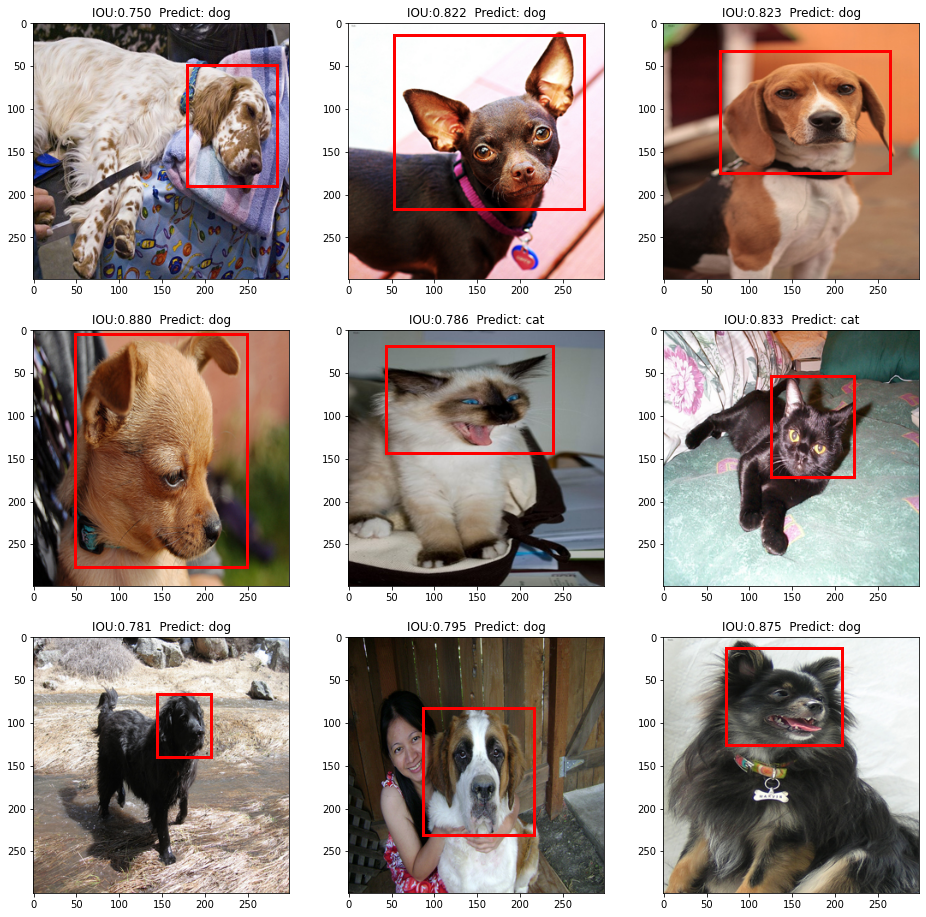

In [ ]:
def show_predict(model,loader):
  num_image = 9
  convert_label = {0:'cat',1:"dog"}
  fig = plt.figure(figsize=(16,16))
  random_index = np.random.randint(0, len(loader.dataset),size=9)
  for i in range(num_image):
    # part of predict neural network
    a = fig.add_subplot(3, 3, i + 1)
    image, label, bbox1 = loader.dataset[random_index[i]]
    image_for_graph = copy.deepcopy(image)
    image = image.unsqueeze(0)
    pred,bbox2 = model(image)
    predict = torch.round(pred)
    bbox2 = 299*bbox2.detach().numpy()
    #part of visualization
    image_for_graph = transforms.ToPILImage()(image_for_graph)
    plt.gca().add_patch(show_bbox(bbox2[0]))
    plt.imshow(image_for_graph)
    a.set_title("IOU:%.3f  Predict: %s" %(IOU(bbox1,bbox2[0]),convert_label[int(predict)]))
show_predict(Dmodel.to(device),val_loader)